In [3]:
%reload_ext autoreload
%autoreload 2


In [4]:
#!/usr/bin/env python
# -*- coding:utf-8 -*-
#
# Created: 03/2022
# Author: Carmelo Mordini <cmordini@phys.ethz.ch>

import matplotlib.pyplot as plt
from scipy import signal as sg

dt = 392e-9
fs = 1 / dt  # waveform sample rate

R1 = 200
C1 = 10e-9
R2 = 180
C2 = 33e-9

tau1 = R1 * C1
tau2 = R2 * C2

zpk_analog = [], [-1 / tau1, -1 / tau2], 1 / tau1 / tau2
zpk_dig = sg.bilinear_zpk(*zpk_analog, fs)
b, a = sg.zpk2tf(*zpk_dig)

# cryo_filter = sg.dlti(b, a, dt=dt)
_trap_filter = b, a, dt

In [10]:
#!/usr/bin/env python
# -*- coding:utf-8 -*-
#
# Created: 03/2022
# Author: Carmelo Mordini <cmordini@phys.ethz.ch>


import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sg

from pytrans import objectives as obj
from pytrans.solver import solver
from models.surface_trap import SurfaceTrap

from pytrans.filter import lfilter_waveform, pad_waveform


trap = SurfaceTrap(["DCintop"])

_t = np.arange(256)
voltage0 = sg.sawtooth(2 * np.pi * 4 * _t / _t.max(), width=0.5)

step_objectives = [
    [obj.VoltageObjective([v])]
    for v in voltage0
]

# step_objectives.extend([step_objectives[-1]] * 50)

global_objectives = [
    obj.SlewRateObjective(weight=1),
    obj.SlewRateObjective(1e6, constraint_type='<='),
    # obj.VoltageObjective(10, constraint_type='<='),
    # obj.VoltageObjective(-10, constraint_type='>=')
]

# trap_filter = None
trap_filter = _trap_filter
# step_objectives[0][0].weight *= 10

print("Running solver")
# start_value = np.tile(v_start, (len(step_objectives), 1))
waveform0 = solver(trap, step_objectives, global_objectives, trap_filter=trap_filter, verbose=True)
print("done")



Running solver
(306, 404)
waveform.shape[0] 306
len(step_objective) 306


Compiling step objectives: 100%|██████████| 306/306 [00:02<00:00, 121.75it/s]


                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Jun 16 11:14:04 AM: Your problem has 124028 variables, 149 constraints, and 0 parameters.
(CVXPY) Jun 16 11:14:04 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 16 11:14:04 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 16 11:14:04 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 16 11:14:04 AM: Compiling problem (target solver=MOSEK).
(CVXPY) Jun 16 11:14:04 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuf

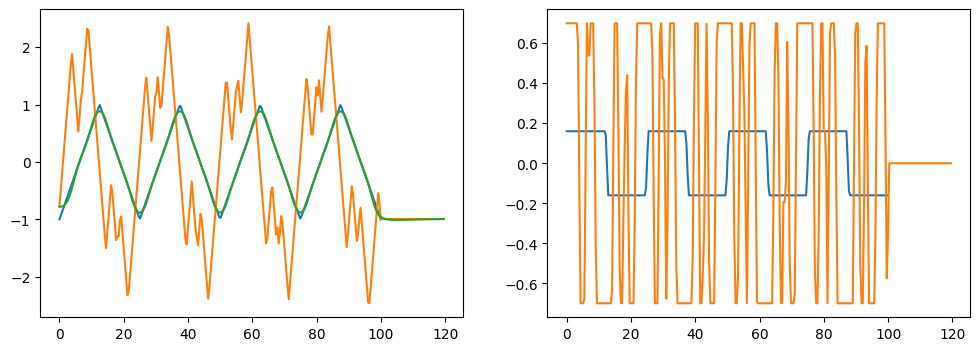

In [9]:

b, a, dt = _trap_filter
n_pad = 50
tt = _t * dt * 1e6
tf = np.arange(len(waveform0) + n_pad) * dt * 1e6
waveform_filt = lfilter_waveform(b, a, waveform0, pad_after=n_pad)
voltage = voltage0
waveform = pad_waveform(waveform0, n_pad)


fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 4))
ax.plot(tt, voltage)
ax.plot(tf, waveform)
ax.plot(tf, waveform_filt)
# plt.ylim(-2.3, 2.3)

dv = np.gradient(voltage, tt, axis=0)
dw = np.gradient(waveform, tf, axis=0)

ax1.plot(tt, dv)
ax1.plot(tf, dw)




In [7]:
waveform.shape

(306, 1)